In [1]:
import itertools
# 
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pandas_ta as ta
import yfinance as yf
# 
from sklearn.preprocessing import StandardScaler
from xgboost import XGBClassifier

In [2]:
# parameters
num_class = 5
split_date = '2023-04-01'
random_state=42
start_date = '2007-01-01'
end_date = '2024-05-01'

In [3]:
# daily data download
df = yf.download('GC=F', start=start_date, end=end_date)
df.drop(columns=['Volume','Adj Close'], inplace=True)
df.sort_values(by=['Date'],inplace=True)
df.reset_index(inplace=True)
df

[*********************100%%**********************]  1 of 1 completed


,Date,Open,High,Low,Close
0,2007-01-02,635.200012,635.200012,635.200012,635.200012
1,2007-01-03,640.400024,640.400024,628.500000,627.099976
2,2007-01-04,624.500000,624.500000,624.500000,623.900024
3,2007-01-05,623.700012,623.700012,617.299988,604.900024
4,2007-01-08,607.500000,607.500000,607.500000,607.500000
...,...,...,...,...,...
4355,2024-04-24,2321.300049,2328.699951,2314.600098,2324.500000
4356,2024-04-25,2315.000000,2329.800049,2305.000000,2329.800049
4357,2024-04-26,2347.899902,2347.899902,2332.800049,2334.800049
4358,2024-04-29,2334.800049,2345.500000,2327.899902,2345.399902


In [4]:
# Feature Engineering (on Returns, not on Price)
# returns for Features (no look-ahead bias):
df['Rp'] = df['Close'].pct_change()
# 
ema_14_rp = df.ta.ema(length=14, close='Rp')
rsi_14_rp = df.ta.rsi(length=14, close='Rp')
emsd_rp = df['Rp'] - ema_14_rp
# Assign the resulting columns to the DataFrame with desired names
df['Rp_ema_14'] = ema_14_rp
df['Rp_rsi_14'] = rsi_14_rp
df['EMSD_Rp'] = emsd_rp
# target
df['Rp'] = df['Close'].pct_change().shift(-1)
# 
df

,Date,Open,High,Low,Close,Rp,Rp_ema_14,Rp_rsi_14,EMSD_Rp
0,2007-01-02,635.200012,635.200012,635.200012,635.200012,-0.012752,NaN,NaN,NaN
1,2007-01-03,640.400024,640.400024,628.500000,627.099976,-0.005103,NaN,NaN,NaN
2,2007-01-04,624.500000,624.500000,624.500000,623.900024,-0.030454,NaN,NaN,NaN
3,2007-01-05,623.700012,623.700012,617.299988,604.900024,0.004298,NaN,NaN,NaN
4,2007-01-08,607.500000,607.500000,607.500000,607.500000,0.009218,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...
4355,2024-04-24,2321.300049,2328.699951,2314.600098,2324.500000,0.002280,-0.000494,49.080349,-0.000881
4356,2024-04-25,2315.000000,2329.800049,2305.000000,2329.800049,0.002146,-0.000124,50.320284,0.002404
4357,2024-04-26,2347.899902,2347.899902,2332.800049,2334.800049,0.004540,0.000178,50.271958,0.001968
4358,2024-04-29,2334.800049,2345.500000,2327.899902,2345.399902,-0.023024,0.000760,51.174243,0.003780


In [5]:
# training quantiles training
features = ['Rp_ema_14','Rp_rsi_14','EMSD_Rp']
target = 'Rp'
df.dropna(inplace=True)
train_df = df.loc[df.Date < split_date]
test_df = df.loc[df.Date >= split_date]
X_train = train_df[features].values
y_train = train_df[target].values
X_test = test_df[features].values
y_test = test_df[target].values
# scaling
scaler = StandardScaler()
scaler.fit(X_train)
X_train_scaled = scaler.transform(X_train)
X_test_scaled = scaler.transform(X_test)
y_train_quantiles = pd.qcut(y_train, q=num_class, labels=False)

In [6]:
# class prediction
xgb_classifier = XGBClassifier(objective='multi:softmax', num_class=num_class, random_state=random_state)
xgb_classifier.fit(X_train_scaled, y_train_quantiles)
# Predict classes for the test sample
y_train_test = xgb_classifier.predict(X_train_scaled)
y_pred_test = xgb_classifier.predict(X_test_scaled)
y_pred_all = np.concatenate((y_train_test, y_pred_test))
df['Predicted_Class'] = y_pred_all
df

,Date,Open,High,Low,Close,Rp,Rp_ema_14,Rp_rsi_14,EMSD_Rp,Predicted_Class
15,2007-01-24,640.299988,640.299988,640.299988,647.599976,0.000309,0.002555,51.980367,0.001165,2
16,2007-01-25,647.799988,647.799988,647.799988,647.799988,-0.005094,0.002255,50.792984,-0.001946,1
17,2007-01-26,644.500000,644.500000,644.500000,644.500000,-0.002172,0.001275,48.887928,-0.006370,1
18,2007-01-29,643.099976,643.099976,643.099976,643.099976,0.001711,0.000816,49.980514,-0.002988,2
19,2007-01-30,643.000000,647.500000,640.799988,644.200012,0.012108,0.000935,51.465255,0.000776,4
...,...,...,...,...,...,...,...,...,...,...
4354,2024-04-23,2327.699951,2330.800049,2294.199951,2327.699951,-0.001375,-0.000359,48.900582,-0.001571,1
4355,2024-04-24,2321.300049,2328.699951,2314.600098,2324.500000,0.002280,-0.000494,49.080349,-0.000881,3
4356,2024-04-25,2315.000000,2329.800049,2305.000000,2329.800049,0.002146,-0.000124,50.320284,0.002404,2
4357,2024-04-26,2347.899902,2347.899902,2332.800049,2334.800049,0.004540,0.000178,50.271958,0.001968,3


In [7]:
# returns profile
conditions = [df['Predicted_Class'].isin([0,1,2,3,4]) # long
              , df['Predicted_Class'].isin([0,1,2,3,4]) # short
              ]
signals = [1
           , -1]
# Create the "signal" column using np.select
df['signal'] = np.select(conditions, signals, default=0)
df['returns'] = df['signal']*df['Rp']
# Returns IS
df['cum_returns'] = (df['returns'] + 1).cumprod()
# sharpe ratios
std_dev = df['returns'].std()*np.sqrt(252)
ar = df['returns'].cumsum().iloc[-1]/((len(df)+1)/365.2)
sharpe_ratio = ar / std_dev
print("sharpe_ratio IS:",sharpe_ratio)
# Returns OOS
test_df = df.loc[df.Date >= split_date].copy()
test_df['cum_returns'] = (test_df['returns'] + 1).cumprod()
# sharpe ratios
std_dev = test_df['returns'].std()*np.sqrt(252)
ar = test_df['returns'].cumsum().iloc[-1]/((len(test_df)+1)/365.2)
sharpe_ratio = ar / std_dev
print("sharpe_ratio OOS:",sharpe_ratio)

sharpe_ratio IS: 0.7322819787113833
sharpe_ratio OOS: 1.6385552139152284


In [8]:
all_classes = list(range(num_class))
# Initialize a DataFrame to store the Sharpe ratios for each combination
sharpe_ratios_df = []
# Generate all possible combinations of long and short classes
for subset_length in range(num_class + 1):
    for long_classes in itertools.combinations(all_classes, r=subset_length):
        print(long_classes)
        short_classes = [item for item in all_classes if item not in long_classes]
        # Filter data based on the long and short classes
        long_condition = df['Predicted_Class'].isin(long_classes)
        short_condition = df['Predicted_Class'].isin(short_classes)
        df['signal'] = np.select([long_condition, short_condition], [1, -1], default=0)
        # Calculate returns
        df['returns'] = df['signal'] * df['Rp']
        # Calculate cumulative returns
        df['cum_returns'] = (df['returns'] + 1).cumprod()
        # Calculate Sharpe ratio for in-sample data
        std_dev_is = df['returns'].std() * np.sqrt(252)
        ar_is = df['returns'].cumsum().iloc[-1] / ((len(df) + 1) / 365.2)
        sharpe_ratio_is = ar_is / std_dev_is
        # Filter test data based on split_date
        test_df = df.loc[df.Date >= split_date].copy()
        # Calculate Sharpe ratio for out-of-sample data
        std_dev_oos = test_df['returns'].std() * np.sqrt(252)
        ar_oos = test_df['returns'].cumsum().iloc[-1] / ((len(test_df) + 1) / 365.2)
        sharpe_ratio_oos = ar_oos / std_dev_oos
        # Append the Sharpe ratios to the DataFrame
        sharpe_ratios_df.append({'Long_Classes': long_classes,
                                                    'Short_Classes': short_classes,
                                                    'Sharpe_Ratio_IS': sharpe_ratio_is,
                                                    'Sharpe_Ratio_OOS': sharpe_ratio_oos
                                                    })
sharpe_ratios_df = pd.DataFrame(sharpe_ratios_df)

()
(0,)
(1,)
(2,)
(3,)
(4,)
(0, 1)
(0, 2)
(0, 3)
(0, 4)
(1, 2)
(1, 3)
(1, 4)
(2, 3)
(2, 4)
(3, 4)
(0, 1, 2)
(0, 1, 3)
(0, 1, 4)
(0, 2, 3)
(0, 2, 4)
(0, 3, 4)
(1, 2, 3)
(1, 2, 4)
(1, 3, 4)
(2, 3, 4)
(0, 1, 2, 3)
(0, 1, 2, 4)
(0, 1, 3, 4)
(0, 2, 3, 4)
(1, 2, 3, 4)
(0, 1, 2, 3, 4)


In [9]:
sharpe_ratios_df.sort_values(by=['Sharpe_Ratio_IS'], ascending=[False],inplace=True)
sharpe_ratios_df

,Long_Classes,Short_Classes,Sharpe_Ratio_IS,Sharpe_Ratio_OOS
25,"(2, 3, 4)","[0, 1]",15.022989,1.423333
15,"(3, 4)","[0, 1, 2]",13.858448,-2.107591
30,"(1, 2, 3, 4)",[0],11.774985,2.281217
24,"(1, 3, 4)","[0, 2]",10.797204,-1.251196
14,"(2, 4)","[0, 1, 3]",10.338951,2.605952
5,"(4,)","[0, 1, 2, 3]",9.426773,-0.930850
23,"(1, 2, 4)","[0, 3]",7.737570,3.478093
12,"(1, 4)","[0, 2, 3]",6.919658,-0.080706
13,"(2, 3)","[0, 1, 4]",3.152104,0.716649
29,"(0, 2, 3, 4)",[1],2.849764,0.785457


In [10]:
sharpe_ratios_df.sort_values(by=['Sharpe_Ratio_OOS'], ascending=[False],inplace=True)
sharpe_ratios_df

,Long_Classes,Short_Classes,Sharpe_Ratio_IS,Sharpe_Ratio_OOS
23,"(1, 2, 4)","[0, 3]",7.737570,3.478093
27,"(0, 1, 2, 4)",[3],-2.428940,2.824269
10,"(1, 2)","[0, 3, 4]",-2.129807,2.754036
14,"(2, 4)","[0, 1, 3]",10.338951,2.605952
30,"(1, 2, 3, 4)",[0],11.774985,2.281217
16,"(0, 1, 2)","[3, 4]",-13.858448,2.107591
20,"(0, 2, 4)","[1, 3]",-0.319313,1.960780
3,"(2,)","[0, 1, 3, 4]",-0.024510,1.891352
31,"(0, 1, 2, 3, 4)",[],0.732282,1.638555
22,"(1, 2, 3)","[0, 4]",1.027708,1.569352


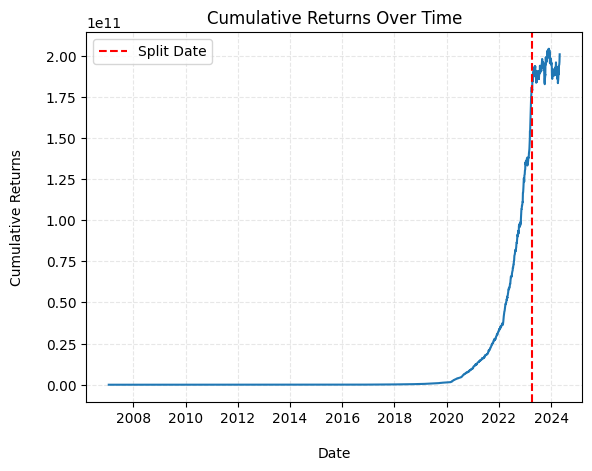

In [11]:
long_classes = [2,3,4]
short_classes = [item for item in all_classes if item not in long_classes]
# Filter data based on the long and short classes
long_condition = df['Predicted_Class'].isin(long_classes)
short_condition = df['Predicted_Class'].isin(short_classes)
df['signal'] = np.select([long_condition, short_condition], [1, -1], default=0)
# Calculate returns
df['returns'] = df['signal'] * df['Rp']
# Calculate cumulative returns
df['cum_returns'] = (df['returns'] + 1).cumprod()

# Plot the cumulative results
plt.plot(df['Date'],df['cum_returns'])
plt.xlabel('\nDate')
# plt.xticks(df['Date'], rotation=90)
plt.ylabel('Cumulative Returns\n')
plt.title('Cumulative Returns Over Time')
plt.grid(True,alpha=0.3,linestyle='--')
split_date = pd.to_datetime(split_date)
plt.axvline(x=split_date, color='r', linestyle='--', label='Split Date')
plt.legend()
plt.show()